In [2]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [3]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,35068,None,None,85787.553903
2020-06-13,35069,None,None,79702.353864
2020-06-14,35070,None,None,74050.454941
2020-06-15,35071,None,None,68726.018859
2020-06-16,35072,None,None,63983.746233
...,...,...,...,...
2021-02-26,35327,None,None,150473.537752
2021-02-27,35328,None,None,148136.983053
2021-02-28,35329,None,None,145680.406809


In [4]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-02_2021-03-02-16-08.pickle


In [5]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-01_2021-03-01-16-29.pickle


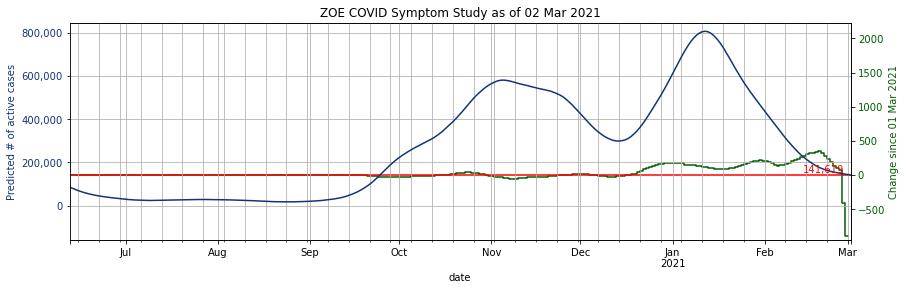

In [6]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

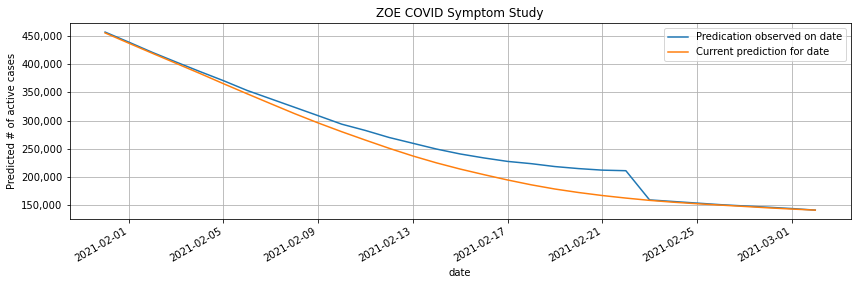

In [7]:
plot_study_evolution(curr_date, days=30)

In [8]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [9]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-02_2021-03-02-16-08.pickle


In [10]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
69,Dacorum,E07000096,1.124555
297,Falkirk,S12000014,0.999017
15,"Kingston upon Hull, City of",E06000010,0.894578
260,Coventry,E08000026,0.870177
241,North Warwickshire,E07000218,0.836048
300,Bradford,E08000032,0.769976
298,Fife,S12000015,0.729274
19,Derby,E06000015,0.708653
100,Erewash,E07000036,0.687249
189,West Lindsey,E07000142,0.626203
